In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import EarlyStopping
import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

In [5]:
#Dataset load
ds_train = pd.read_csv("/clear_dataset.zip" , compression="zip")

In [6]:
ds_train.head()

,passenger_count,trip_duration,month_pickup,dow_pickup,hour_pickup,BoroCode,BoroName,dist_km,average_speed
0,1,455,3,0,17,1,Manhattan,1.498521,11.856428
1,1,663,6,6,0,1,Manhattan,1.805507,9.803659
2,1,2124,1,1,11,1,Manhattan,6.385098,10.822201
3,1,429,4,2,19,1,Manhattan,1.485498,12.465721
4,1,435,3,5,13,1,Manhattan,1.188588,9.836594


### One hot encoding categorical features

In [7]:
#one hot encoding variable "BoroCode"
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('int64')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
ds_train = oneHotEncode(ds_train, ["BoroCode"])

### Circular predictors for hours, month and day_of_week variables

In [8]:
#hours
ds_train['sin_hour_pickup'] = np.sin(2*np.pi*ds_train.hour_pickup/24)
ds_train['cos__hour_pickup'] = np.cos(2*np.pi*ds_train.hour_pickup/24)
ds_train.drop('hour_pickup', axis=1, inplace=True)

In [9]:
#month
ds_train['sin_month_pickup'] = np.sin(2*np.pi*ds_train.month_pickup/12)
ds_train['cos__month_pickup'] = np.cos(2*np.pi*ds_train.month_pickup/12)
ds_train.drop('month_pickup', axis=1, inplace=True)

In [10]:
#day of the week
ds_train['sin_dow_pickup'] = np.sin(2*np.pi*ds_train.dow_pickup/7)
ds_train['cos__dow_pickup'] = np.cos(2*np.pi*ds_train.dow_pickup/7)
ds_train.drop('dow_pickup', axis=1, inplace=True)

### Feature selection


Removal average speed since it is calculated based on the predicted variable

In [11]:
ds_train.drop(['average_speed', "BoroName"], axis=1, inplace=True)

### Y and X variables


In [12]:
#predict variable split
y_values = ds_train["trip_duration"]
x_values = ds_train.drop(["trip_duration"],axis=1)

## Random forest model as benchmark

In [ ]:
#split in train e validation set
train_X, val_X, train_y, val_y = train_test_split(x_values, y_values, test_size = 0.25, random_state = 12)

random_grid = {'max_depth': [5, 10, 12, 14]}
random_forest = RandomForestRegressor()
random_forest_grid = RandomizedSearchCV(estimator = random_forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

random_forest_grid.fit(train_X, train_y)

predicted_trip_duration = random_forest_grid.predict(val_X)
MSLE = 	mean_squared_log_error(val_y , predicted_trip_duration)
print('Random forest validation MSLE = ', MSLE)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Random forest validation MSLE =  0.18749680681619824


In [ ]:
random_forest_grid.best_estimator_

RandomForestRegressor(max_depth=12)

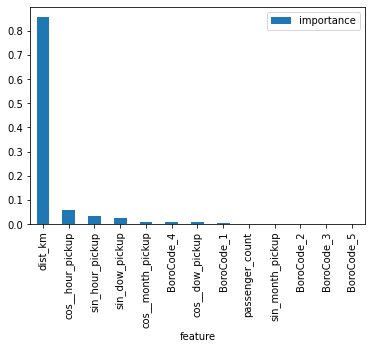

In [ ]:
importances = pd.DataFrame({'feature':train_X.columns,'importance':np.round(random_forest_grid.best_estimator_.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()

# Train vanilla neural network

In [66]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = ds_train.shape[1]-1, activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer='adam', metrics=keras.losses.MeanSquaredLogarithmicError())
NN_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 128)               1792      
                                                                 
 dense_31 (Dense)            (None, 256)               33024     
                                                                 
 dense_32 (Dense)            (None, 256)               65792     
                                                                 
 dense_33 (Dense)            (None, 256)               65792     
                                                                 
 dense_34 (Dense)            (None, 1)                 257       
                                                                 
Total params: 166,657
Trainable params: 166,657
Non-trainable params: 0
_________________________________________________________________


In [67]:
#set checkpoints
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_mean_squared_logarithmic_error', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [68]:
history = NN_model.fit(x_values, y_values, epochs=50, batch_size=1024, validation_split = 0.25, callbacks=[callbacks_list])


Epoch 1/50
1061/1062 [============================>.] - ETA: 0s - loss: 0.7781 - mean_squared_logarithmic_error: 0.7781
Epoch 1: val_mean_squared_logarithmic_error improved from inf to 0.19462, saving model to Weights-001--0.19456.hdf5
1062/1062 [==============================] - 35s 33ms/step - loss: 0.7777 - mean_squared_logarithmic_error: 0.7775 - val_loss: 0.1946 - val_mean_squared_logarithmic_error: 0.1946
Epoch 2/50
1061/1062 [============================>.] - ETA: 0s - loss: 0.1789 - mean_squared_logarithmic_error: 0.1789
Epoch 2: val_mean_squared_logarithmic_error improved from 0.19462 to 0.19258, saving model to Weights-002--0.19253.hdf5
1062/1062 [==============================] - 32s 30ms/step - loss: 0.1789 - mean_squared_logarithmic_error: 0.1789 - val_loss: 0.1925 - val_mean_squared_logarithmic_error: 0.1926
Epoch 3/50
1062/1062 [==============================] - ETA: 0s - loss: 0.1765 - mean_squared_logarithmic_error: 0.1765
Epoch 3: val_mean_squared_logarithmic_error di

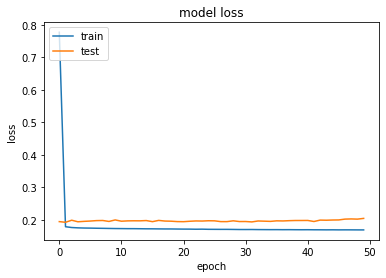

In [69]:
#plot the viz of train and val error
plt.plot(history.history['mean_squared_logarithmic_error'])
plt.plot(history.history['val_mean_squared_logarithmic_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Fix overfitting

Add L2 regularization and dropout

In [70]:
#L2 factor
factor=0.0001
#Dropout rate
rate=0.3

NN_model = Sequential()
# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = ds_train.shape[1]-1, kernel_regularizer=l2(factor), activation='relu'))
NN_model.add

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal', kernel_regularizer=l2(factor), activation='relu'))
NN_model.add(Dropout(rate))
NN_model.add(Dense(256, kernel_initializer='normal', kernel_regularizer=l2(factor), activation='relu'))
NN_model.add(Dropout(rate))
NN_model.add(Dense(256, kernel_initializer='normal', kernel_regularizer=l2(factor), activation='relu'))
NN_model.add(Dropout(rate))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer='adam', metrics=keras.losses.MeanSquaredLogarithmicError())
NN_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 128)               1792      
                                                                 
 dense_36 (Dense)            (None, 256)               33024     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_37 (Dense)            (None, 256)               65792     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_38 (Dense)            (None, 256)               65792     
                                                                 
 dropout_8 (Dropout)         (None, 256)              

In [71]:
#set up early stopping and checkpoints
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_mean_squared_logarithmic_error', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

Add early stop

In [72]:
#fit model
history = NN_model.fit(x_values, y_values, epochs=20, batch_size=1024, validation_split = 0.25, callbacks=[callbacks_list, es])

Epoch 1/20
1061/1062 [============================>.] - ETA: 0s - loss: 0.7519 - mean_squared_logarithmic_error: 0.7104
Epoch 1: val_mean_squared_logarithmic_error improved from inf to 0.19246, saving model to Weights-001--0.22637.hdf5
1062/1062 [==============================] - 45s 41ms/step - loss: 0.7515 - mean_squared_logarithmic_error: 0.7099 - val_loss: 0.2264 - val_mean_squared_logarithmic_error: 0.1925
Epoch 2/20
1061/1062 [============================>.] - ETA: 0s - loss: 0.2185 - mean_squared_logarithmic_error: 0.1892
Epoch 2: val_mean_squared_logarithmic_error improved from 0.19246 to 0.18810, saving model to Weights-002--0.21283.hdf5
1062/1062 [==============================] - 42s 39ms/step - loss: 0.2185 - mean_squared_logarithmic_error: 0.1892 - val_loss: 0.2128 - val_mean_squared_logarithmic_error: 0.1881
Epoch 3/20
1061/1062 [============================>.] - ETA: 0s - loss: 0.2076 - mean_squared_logarithmic_error: 0.1860
Epoch 3: val_mean_squared_logarithmic_error im

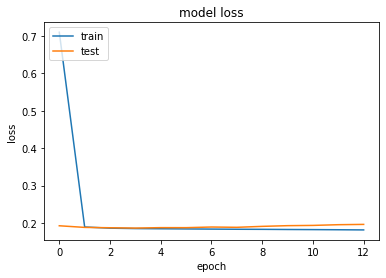

In [73]:
#plot the viz of train and val error
plt.plot(history.history['mean_squared_logarithmic_error'])
plt.plot(history.history['val_mean_squared_logarithmic_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()